## Filtros Digitais aplicados em Finanças: Filtrando a curva do Par USD/JPY

Há um tempo atrás eu vi um analista quant (não lembro se era da Encore ou da Giant Steps) comentando que leu um artigo de telecomunicações e teve a ideia de tentar aplicar um filtro, encontrado no artigo, na curva de câmbio USD/BRL. Mais recentemente, no artigo de Shternshis et al. (2022), vi novamente uma proposta de filtro para remoção de sazonalidade, efeitos espúrios e ruídos microestruturais de dados financeiros. Então fiquei com vontade de estudar a aplicação de diferentes filtros em finanças.

Cabe falar que a área de design de filtros digitais é uma área extensa e em contínuo desenvolvimento. Aqui minha proposta é estudar filtros digitais clássicos: **Média Móvel**, **Filtro Butterworth**, **Filtro Chebyshev**, **Filtro Elíptico** e um **filtro FIR generalizado**. Mas deixo claro que existem inúmeros filtros e combinações de filtros que podem ser úteis em finanças.

Como ex-estudante de engenharia, vou abordar o tema de filtros como um tópico do estudo de sinais e sistemas.

### Objetivo
Neste trabalho exploraremos a aplicação de filtros passa-baixas em um sinal financeiro.

### Sinais e Sistemas

Um **Sinal** é um conjunto de dados ou informação. Esse conjunto pode ser contínuo, $x(t)$, ou discreto, $x[n]$. Um sinal que depende do tempo pode ser comumente chamado de série temporal.

Sinais, em geral, podes ser processados por **Sistemas**, os quais podem modificá-los ou extrair informações. Matemáticamente escrevemos $y(t) = f(x(t))$ para sinais contínuos ou $y[n] = f(x[n])$ para sistemas discretos. Graficamente podemos representar da seguinte forma.

![Sistema Discreto](download.png)

Ainda é possível representar um sistema fisicamente. Um circuito elétrico, por exemplo, é um sistema.

### Filtros

Um **Filtro** então é um sistema que recebe um sinal de entrada e o modifica. Tá, mas esse filtro filtra o que? Frequências. Acontece que um sinal pode ser enxergado como uma soma de sinais com diferentes frquências (Isso é muito interessante, mas não vou aprofundar aqui. Veja [Séries de Fourier](https://en.wikipedia.org/wiki/Fourier_series)). **Quando aplicamos um filtro a esse sinal, conseguimos, a grosso modo, retirar algumas frequências (ou, de outro ponto de vista, ressaltar frequências)**.

Quanto a banda de passagem, existem 4 tipos de filtros:
* Passa-baixas, permite a passagem das componentes de baixa frequência (ou, elimina as componentes de alta frequência);
* passa-altas, permite a passagem das componentes de alta frequência (ou, elimina as componentes de baixa frequência);
* passa-banda, permite a passagem de componentes em um *range* específico de frequências (ou, elimina as componentes fora desse *range*);
* rejeita-banda, permite a passagem de componentes fora de um *range* específico de frequências (ou, elimina as componentes dentro desse *range*).

![Filtros](filtros.png)

De maneira simplificada, **podemos enxergar um sinal temporal financeiro como uma soma de sinais de baixa frequência (variações trimestrais, por exemplo) e sinais de alta frequência (variações diárias, por exemplo).** Dessa forma, ao aplicar um filtro conseguimos "eliminar" algumas dessas frequências. 

Neste trabalho, queremos enxergar tendências de longo prazo no nosso sinal financeiro e, para isso, retiramos as componentes de alta frequência (que podem ser consideradas ruído). Para isso, aplicarei alguns filtros **passa-baixas** e avaliarei os resultados de cada um. 

### Principais Referências
1. [Oppenheim, 1983] Oppenheim, Willsky, Young. **Signals and Systems.** 1983. Prentice-Hall. USA
2. [Shtersnshis, 2022] Shternshis, Andrey & Mazzarisi, Piero & Marmi, Stefano, 2022. **Measuring market efficiency: The Shannon entropy of high-frequency financial time series.** Chaos, Solitons & Fractals, Elsevier, vol. 162(C).
3. [Nepal, 2015] Nepal, S. **Signal Processing in Finance.** Electrical and Computer Engineering Design Handbook, 2015.
4. [Javaheri, 2003] Javaheri, Lautier, Galli. **Filtering in Finance.**, Wilmott Magazine. 2003.
5. [Nielsen, 2021] Nielsen, A. **Análise Prática de Séries Temporais.** 2021. Alta Books.

### Sumário

1. [Tratando os Dados](#tratandoosdados)
2. [Filtros](#filtros)
   1. [Filtros FIR](#fir)
      1. [Média Móvel](#mm)
      2. [Filtro FIR com Janela Hamming](#hamm)
   2. [Filtros IIR](#irr)
      1. [Filtro Butterworth](#butter)
      2. [Filtro Chebyshev](#cheb)
      3. [Filtro Elíptico](#eliptico)

## Pre Code

In [20]:
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
from numpy import loadtxt, savetxt
import random
from typing import List, Tuple
import pandas as pd
from scipy.stats import norm
from scipy.signal import butter, cheby1, ellip, lfilter, firwin

In [21]:
def calculate_log_return(prices):
    log_returns = np.log(prices / prices.shift(1))
    return log_returns

## Tratando os dados
<div id="tratandoosdados"/>

In [22]:
usd_jpy_symbol = 'JPY=X'

start_date = '2010-01-01'
end_date = '2023-01-01'

usd_jpy_data = yf.download(usd_jpy_symbol, start=start_date, end=end_date)

[*********************100%%**********************]  1 of 1 completed


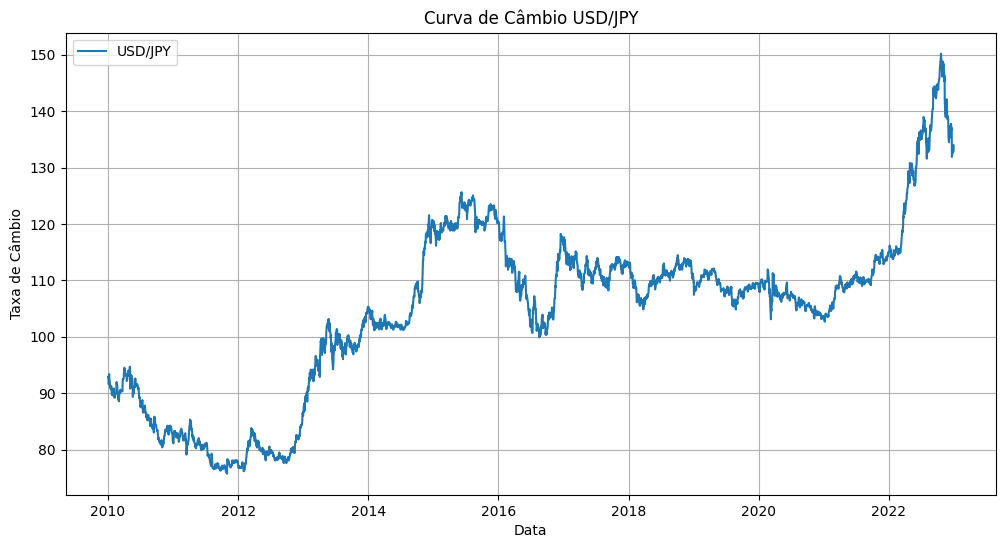

In [23]:
plt.figure(figsize=(12, 6))
plt.plot(usd_jpy_data['Close'], label='USD/JPY')
plt.title('Curva de Câmbio USD/JPY')
plt.xlabel('Data')
plt.ylabel('Taxa de Câmbio')
plt.legend()
plt.grid(True)
plt.show()

Normalmente costuma-se trabalhar com o logaritmo dos retornos ao invés do preço. Por que logaritmo? Porque ele atenua grandes variações, dessa forma ele adiciona *estacionaridade* na sua série temporal.

In [24]:
log_returns = calculate_log_return(usd_jpy_data['Close'])

daily_returns = log_returns.dropna()

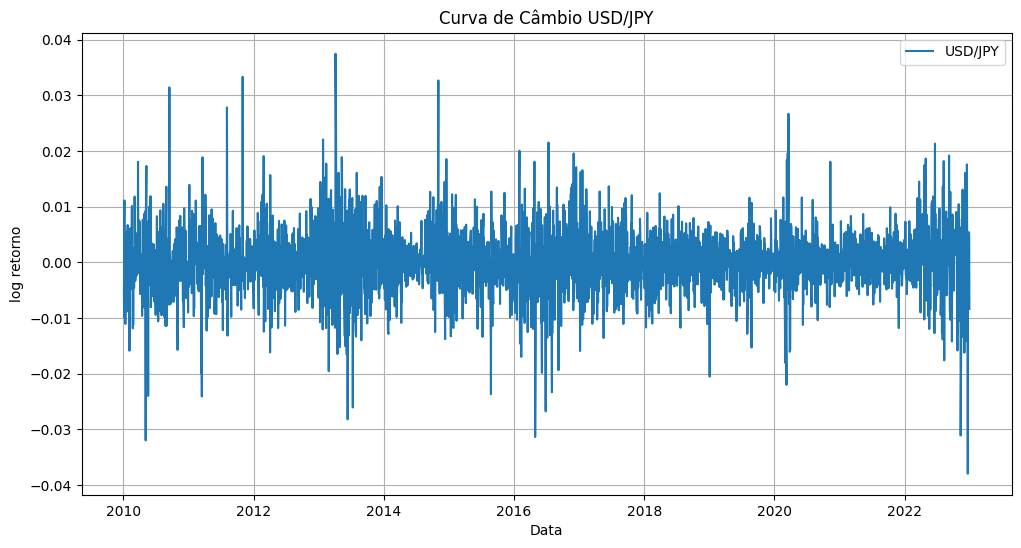

In [25]:
plt.figure(figsize=(12, 6))
plt.plot(daily_returns, label='USD/JPY')
plt.title('Curva de Câmbio USD/JPY')
plt.xlabel('Data')
plt.ylabel('log retorno')
plt.legend()
plt.grid(True)
plt.show()

Vê-se então que temos um retorno logaritmo médio nulo ao longo do tempo, mas com mudanças bruscas na variância em alguns períodos.


#### Decompondo nosso sinal em suas Frequências

Como falei antes, um sinal pode ser visto como uma soma de sinais de diferentes frequências. Mas quais frequências? Quem ajuda a responder essa pergunta é a **Transformada de Fourier**. Ela nos leva do *domínio* do tempo para o *domínio* da frequência. Ela mostra a contribuição de cada frequência para o sinal. 

![ft](ft.jpg)

Denotando um sinal como $x(t)$, escrevemos uma a trasformada de Fourier como $\hat{x}(\omega) = \mathcal{F}\{x(t)\}$, onde $\omega$ é a frequência,

$$
    \hat{x}(\omega) = \mathcal{F}\{x(t)\} = \int_{\mathbb{R}} x(t) e^{-i\omega t} dt.
$$

Para sinais discretos existe a **Discrete Fourier Transform**

$$
    \mathbf{X}(\Omega) = \mathcal{F}\{x[n]\} = \sum_{n=-\infty}^{\infty} x[n] e^{-i\Omega n} = \sum_{n=0}^{N-1} x[n] e^{-\frac{2\pi}{N}i\Omega n}
$$ 

Aqui o $\Omega$ representa a frequência. A transformada de Fourier (na verdade, toda a Análise de Fourier) é uma das coisas mais bonitas da matemática. Abaixo implementaremos a **DFT**.

Entender as frequências do nosso sinal pode dar informações importantes sobre seu comportamento como, por exemplo, ciclos financeiros.

In [26]:
def discrete_fourier_transform(signal):
    N = len(signal)
    n = np.arange(N)
    omega = n.reshape((N, 1))
    e = np.exp(-2j * np.pi * omega * n / N)
    return np.dot(e, signal)

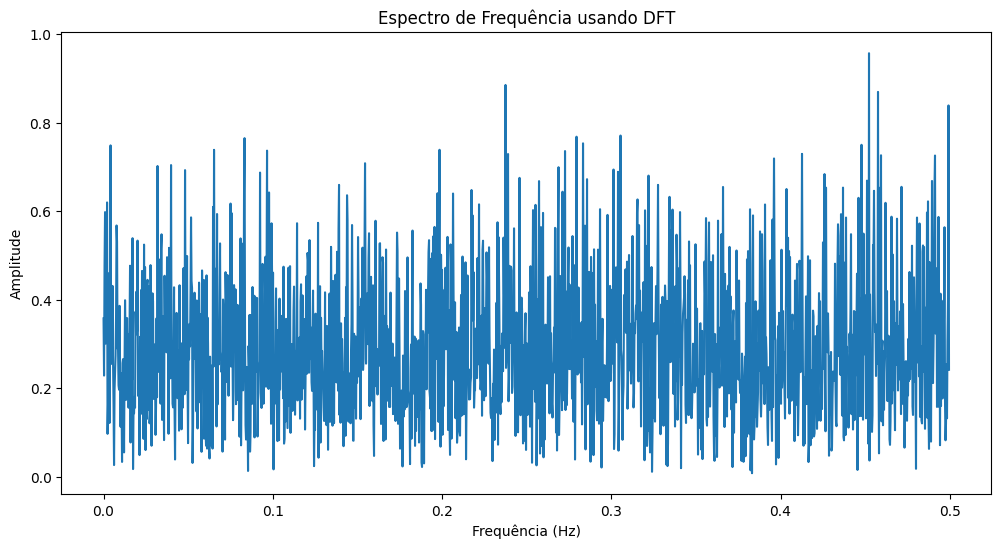

In [27]:
dft_result = discrete_fourier_transform(log_returns.dropna().values)

frequencies = np.fft.fftfreq(len(log_returns.dropna()))

positive_frequencies = frequencies[:len(frequencies)//2]

plt.figure(figsize=(12, 6))
plt.plot(positive_frequencies, np.abs(dft_result)[:len(dft_result)//2])
plt.title('Espectro de Frequência usando DFT')
plt.xlabel('Frequência (Hz)')
plt.ylabel('Amplitude')
plt.show()


Aqui vemos quão complexo é o sinal. Ele é composto de diversas frequências e não tem uma frequência fundamental. Depois de aplicarmos os fitros, vamos ver se isso muda um pouco.

## Filtros
<div id="filtros" />

<div id="fir"/>


### Filtros FIR


Um filtro FIR (finite impulse response), em resumo,é um **filtro não recursivo**, ou seja, um filtro que não é realimentado, depende somente da sequência de entrada $x[n]$.

$$
y[n] = \sum_{k=0}^{M} h[k] \cdot x[n-k]
$$

Onde $h[k]$ é a [resposta ao impulso](https://en.wikipedia.org/wiki/Impulse_response#:~:text=In%20signal%20processing%20and%20control,response%20to%20some%20external%20change.) do sistema.

<div id="mm"/>

#### Média Móvel
A média móvel é um dos filtros FIR passa-baixas mais simples. Basicamente, o que ela faz é calcular a média de pontos próximos que estão em uma *janela* móvel (essa janela é um intervalo de amostras).

![mm](mm.png)

Aqui em azul temos o sinal original, em amarelo nossa janela (intervalo de amostras) e em verde a média.

Podemos escrever matematicamente

$$
\bar{X}[n] = \frac{1}{N}\sum_{k=0}^{N-1} x[n+k], 
$$

onde N é o tamanho da amostra.

Então, o primeiro ponto da média móvel $\bar{X}[1]$, para uma janela $N=15$, por exemplo, é

$$
\bar{X}[1] = \frac{1}{15}( x[1]+x[2]+x[3]+...+x[15])
$$

Agora $\bar{X}[2]$,

$$
\bar{X}[2] = \frac{1}{15}( x[2]+x[3]+x[4]+...+x[16])
$$

e por aí vai.

Qual o efeito que essa média causa? **Ora, a média é bem eficiente em atenuar grandes variações!**


Então definimos, programaticamente, a média móvel. Como estamos lidando com dados diários, a janela escolhida tem unidades de dias. Então escolher $N=30$, por exemplo, significa uma janela mensal.

In [28]:
def moving_average(data, window_size):
    return data.rolling(window=window_size).mean()


#### Média Móvel do Log-Retorno

In [29]:
mm = moving_average(daily_returns, 90)

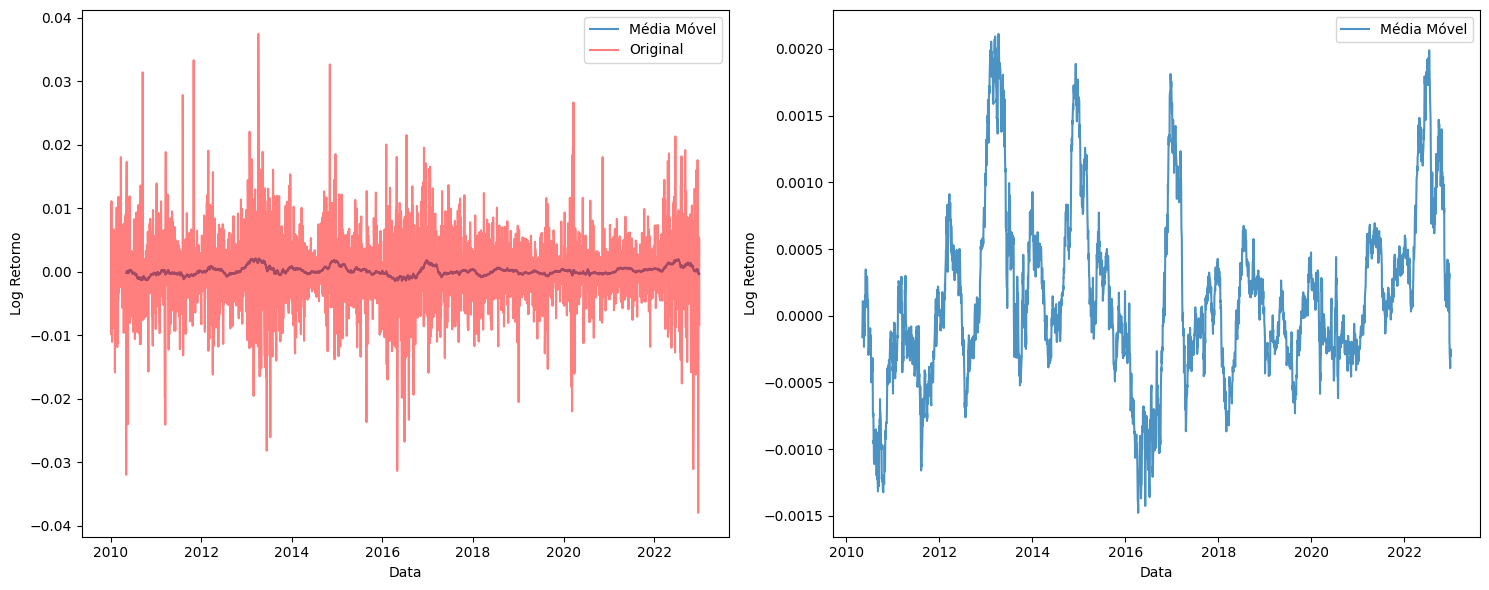

In [30]:
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

axs[0].plot(mm, label='Média Móvel', alpha=0.8)
axs[0].plot(daily_returns, label='Original', color="red", alpha=0.5)
axs[0].set_xlabel('Data')
axs[0].set_ylabel('Log Retorno')
axs[0].legend()


axs[1].plot(mm, label='Média Móvel', alpha=0.8)
axs[1].set_xlabel('Data')
axs[1].set_ylabel('Log Retorno')
axs[1].legend()

plt.tight_layout()

plt.show()

Ao aplicar a média móvel em uma janela trimestral, conseguimos observar a diferença nos sinais. No sinal filtrado observamos claramente um surgimento de padrões, por mais que ainda existam ruídos. Inclusive, conseguimos observar ciclos e uma certa periodicidade.

Podemos aplicar uma média móvel na série de preços também.

In [31]:
mm_precos_90 = moving_average(usd_jpy_data['Close'], 90)
mm_precos_180 = moving_average(usd_jpy_data['Close'], 180)
mm_precos_360 = moving_average(usd_jpy_data['Close'], 360)

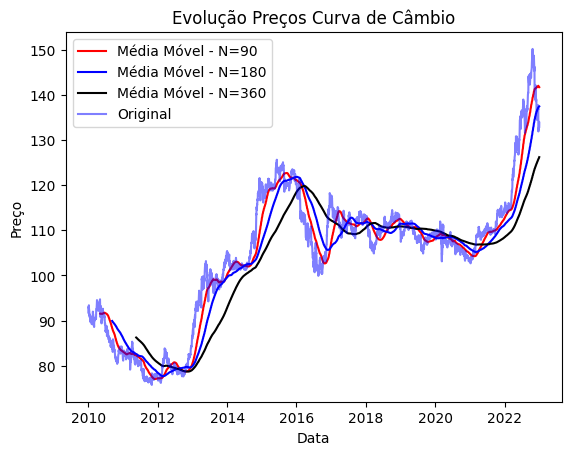

In [32]:
plt.plot(mm_precos_90, color="red", label="Média Móvel - N=90")
plt.plot(mm_precos_180, color="blue", label="Média Móvel - N=180")
plt.plot(mm_precos_360, color="black", label="Média Móvel - N=360")
plt.plot(usd_jpy_data['Close'], color="blue", alpha=0.5, label="Original")
plt.title('Evolução Preços Curva de Câmbio')
plt.xlabel('Data')
plt.ylabel('Preço')
plt.legend()

plt.show()

Aqui observamos algo interessante, quanto maior a janela escolhida maior a suavização do sinal. Porém, percebemos também que quanto maior a janela, maior o *deslocamento de fase*. Quanto mais suavizado o sinal, mais deslocado pra direita. Isso acontece graças a natureza da média móvel.

Podemos também estudar a composição de frequências do sinal filtrado. Para isso, vamos aplicar a DFT igual fizemos antes. Vamos fazer só para janela $N=90$, mas isso é aplicável a todas as outras.

In [33]:
log_returns_filtrado = calculate_log_return(mm_precos_90)

daily_returns_filtrado = log_returns.dropna()

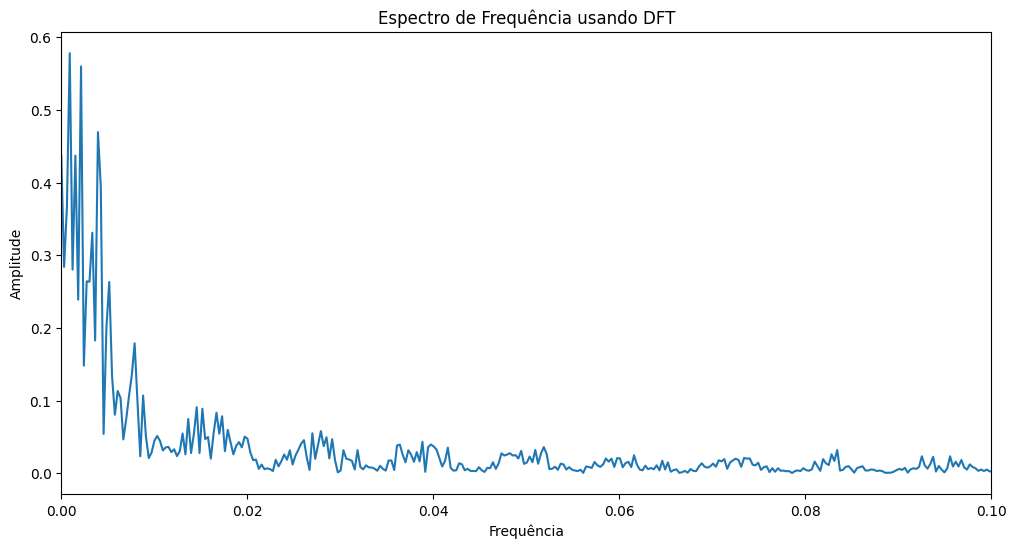

In [34]:
dft_result = discrete_fourier_transform(log_returns_filtrado.dropna().values)

frequencies = np.fft.fftfreq(len(log_returns_filtrado.dropna()))

positive_frequencies = frequencies[:len(frequencies)//2]

plt.figure(figsize=(12, 6))
plt.plot(positive_frequencies, np.abs(dft_result)[:len(dft_result)//2])
plt.title('Espectro de Frequência usando DFT')
plt.xlabel('Frequência')
plt.ylabel('Amplitude')

plt.xlim(0, 0.1)

plt.show()


Notamos então que esse espectro de frequência é bem melhor definido do que o espectro do sinal original. Vemos aqui que as frequências mais representativas se concentram, aproximadamente, entre $0  Hz$ e $0.05 Hz$. Como o período é o inverso da frequência, temos então que nossos períodos mais representativos são os períodos mais longos. Períodos de, aproximadamente, 20 até 100 dias. Ou seja, os principais ciclos se repetem dentro desse *range* de períodos.

<div id="irr"/>

### Filtros IIR

Os filtros IIR (infinity impulse response) são filtros recursivos (ou retroalimentados), ou seja, a saída de um filtro IIR depende das entradas atuais e das anteriores.

$$
    y[n] = \sum_{k=0}^{N} b[k] \cdot x[n-k] - \sum_{m=1}^{M} a[m] \cdot y[n-m]
$$

Alguns dos filtros IIR mais clássicos são os filtros Butterworth, Chebyshev e Elíptico. O que diferencia esses filtros é justamente a velocidade de atenuação das frequências fora da banda de passagem.

![filtrosiir](filtros2.png)

Vemos que o Butterworth atenua o sinal filtrado de uma forma mais suave. Por outro lado, o Chebyshev atenua de uma forma um pouco mais rápida. Porém, esse tipo de filtro tem uma certa flutuação de frequências. Por último, o filtro elípitico atenua o sinal de uma forma bastante abrupta e também apresenta flutuações de frequência. Essas flutuações podem prejudicar aplicações mais críticas e que precisam de mais precisão.

Os filtros IIR são um pouco mais complexos que os filtros FIR. Enquanto na média móvel, por exemplo, só precisamos informar a janela $N$, nos filtros IIR que veremos aqui precisamos passar uma **frequência de corte**, **frequência de amostragem** e **ordem do filtro**.

A **frequência de corte**, $f_{c}$, diz quais frequências o filtro "permitirá" a passagem. Um filtro passa-baixas, por exemplo, só permite a passagem de frequências $f$ tal que $f\leq f_{c}$.

A **frequência de amostragem**, $f_{s}$, representa o número de amostras coletadas por unidade de tempo. No nosso caso, como temos dados diários,
$$
f_{s}=\frac{1}{\Delta t} = \frac{1}{86400 \ s} = 1.16 \times 10^{-5} Hz
$$

Já a **ordem do filtro** informa o quão rápido ele atenuará as frequências fora da banda de passagem. Em resumo, quanto maior a ordem do filtro, mais rápido ele atenuará as frequências fora da banda de passagem. A relação da atenuação em decibéis, $A$, e da ordem, $m$, é

$$
    A = 20 \cdot m \cdot log_{10}\left(\frac{f}{f_{c}}\right)
$$

Além desses parâmetros, os filtros IIR levam em consideração diversos outros aspectos do sinal de forma que, em prol da didática, vamos realizar um *downsampling* do nosso sinal, reduzir as amostras. Porém, vale ressaltar que em uma aplicação da vida real é preciso fazer um *projeto de filtro*.

Os filtros são normalmente definidos pela sua **função de transferência**. A função de transferência, por definição, é a relação entre a entrada e a saída de um sistema.

$$
H(z) = \frac{Y(z)}{X(z)} = \frac{\mathcal{Z}\{ y[n]\}}{\mathcal{Z}\{ x[n]\}}
$$

Aqui, $\mathcal{Z}\{ y[n]\}$ é a [transformada Z](https://en.wikipedia.org/wiki/Z-transform) do sinal de saída. A transformada Z é similar a transformada de Laplace (inclusive, em sinais contínuos, a função de transferência é calculada utilizando a transf. de Laplace dos sinais).

Então, dado a função de transferência $H(z)$, podemos utilizar a transformada Z inversa para encontrar o sinal filtrado $y[n]$.

$$
    Y(z) = H(z) \cdot X(z) \Rightarrow y[n] = \mathcal{Z}^{-1}\{ Y(z)\}
$$

Felizmente não vamos implementar isso "na mão", o *scipy* pode nos ajudar com isso.

Fazendo o downsampling

In [35]:
usd_jpy_data_subset = usd_jpy_data['2020-01-01':'2023-01-01']

<div id="butter" />

#### Filtro Butterworth

O filtro Butterworth tem uma função de transferência da seguinte forma

$$
H(z) = \frac{1}{1+(e^{if}/f_{c})^{2m}}.
$$

Onde $f_{c}$ é a frequência de corte e $m$ é a ordem do filtro.

In [36]:
def butter_lowpass(data, cutoff_freq, sampling_freq, order=4):
    nyquist = 0.5 * sampling_freq
    normal_cutoff = cutoff_freq / nyquist

    if normal_cutoff >= 1.0:
        raise ValueError("A frequência de corte normalizada deve ser menor que 1.0")

    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    filtered_data = lfilter(b, a, data)
    return filtered_data

In [37]:
log_returns = calculate_log_return(usd_jpy_data_subset['Close'])

daily_returns = log_returns.dropna()

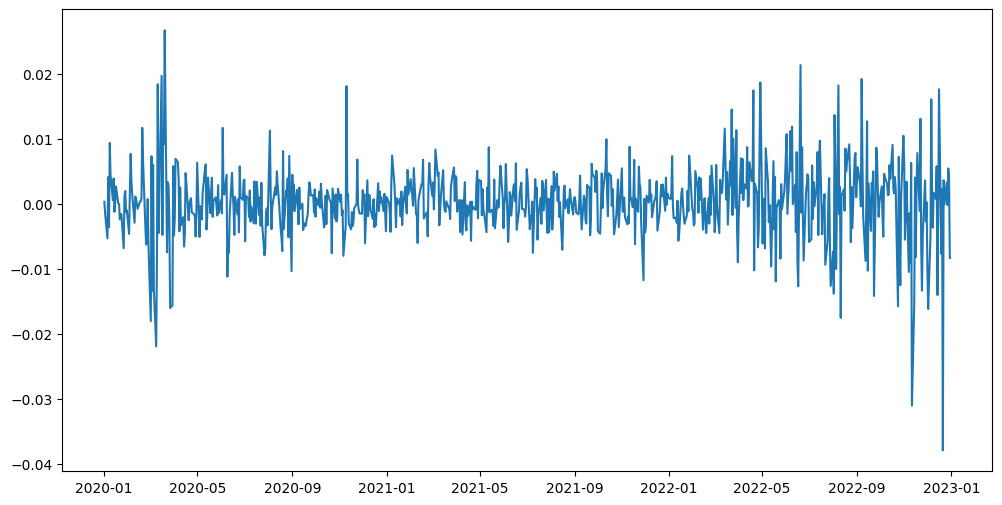

In [38]:
plt.figure(figsize=(12, 6))
plt.plot(daily_returns)

##### Filtrando o Log Retorno

In [39]:
sampling_frequency = 1.0  

filtered_log_return2 = butter_lowpass(daily_returns, 0.02, sampling_frequency, 4)
filtered_log_return4 = butter_lowpass(daily_returns, 0.04, sampling_frequency, 4)

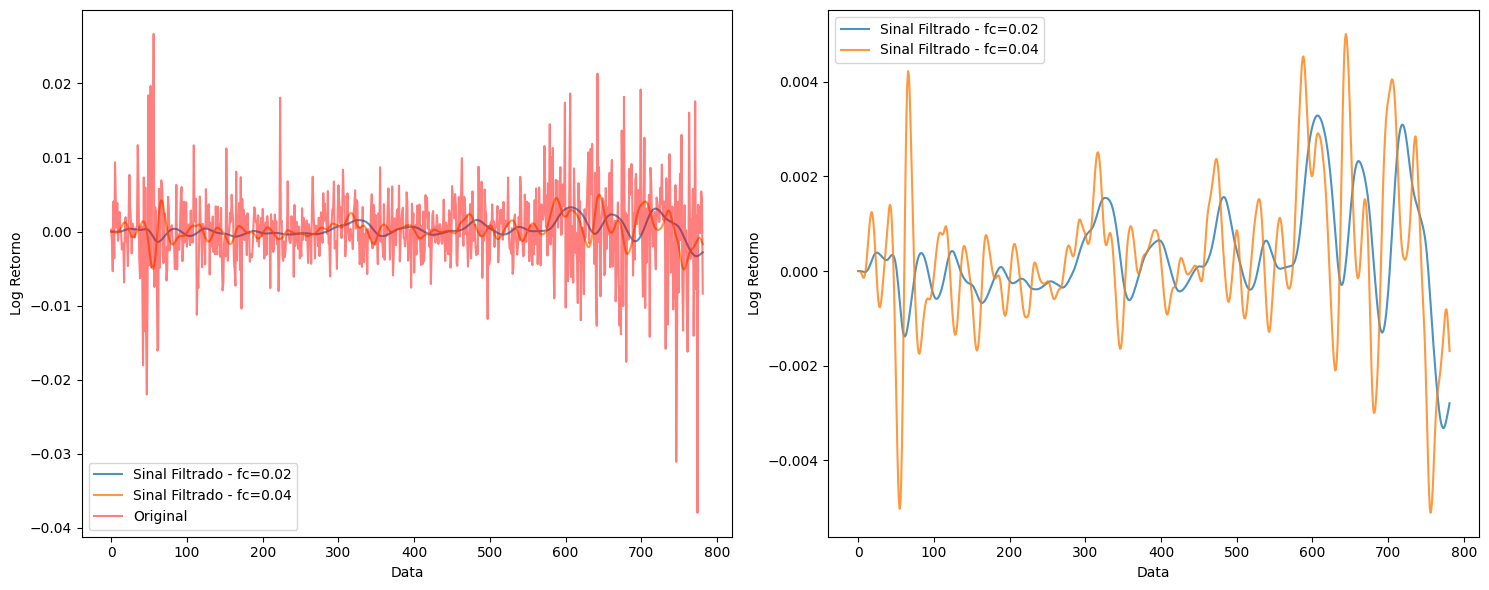

In [40]:
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

axs[0].plot(np.arange(len(filtered_log_return2)),filtered_log_return2, label='Sinal Filtrado - fc=0.02', alpha=0.8)
axs[0].plot(np.arange(len(filtered_log_return4)),filtered_log_return4, label='Sinal Filtrado - fc=0.04', alpha=0.8)
axs[0].plot(np.arange(len(filtered_log_return2)),daily_returns, label='Original', color="red", alpha=0.5)
axs[0].set_xlabel('Data')
axs[0].set_ylabel('Log Retorno')
axs[0].legend()


axs[1].plot(filtered_log_return2, label='Sinal Filtrado - fc=0.02', alpha=0.8)
axs[1].plot(filtered_log_return4, label='Sinal Filtrado - fc=0.04', alpha=0.8)
axs[1].set_xlabel('Data')
axs[1].set_ylabel('Log Retorno')
axs[1].legend()

plt.tight_layout()

plt.show()

Aqui já notamos uma diferença em relação ao filtro por média móvel. No filtro MM, o sinal filtrado ainda mantem um certo aspecto ruidoso, já aqui o sinal filtrado apresenta menos ruído (isso também tem relação com o *downsampling* que fizemos). Novamente, ao filtrar o log retorno, observamos ciclos bem definidos. E percebemos que quanto menor a frequência de corte mais suavizado o sinal fica. Isso acontece pois, em um filtro passa-baixas, quanto menor a frequência de corte, menor são as frequências que o filtro permite passagem.

##### Filtrando a série de Preços

In [41]:
sampling_frequency = 1.0  

filtered_log_return_2 = butter_lowpass(usd_jpy_data_subset['Close'], 0.02, sampling_frequency, 4)
filtered_log_return_4 = butter_lowpass(usd_jpy_data_subset['Close'], 0.04, sampling_frequency, 4)

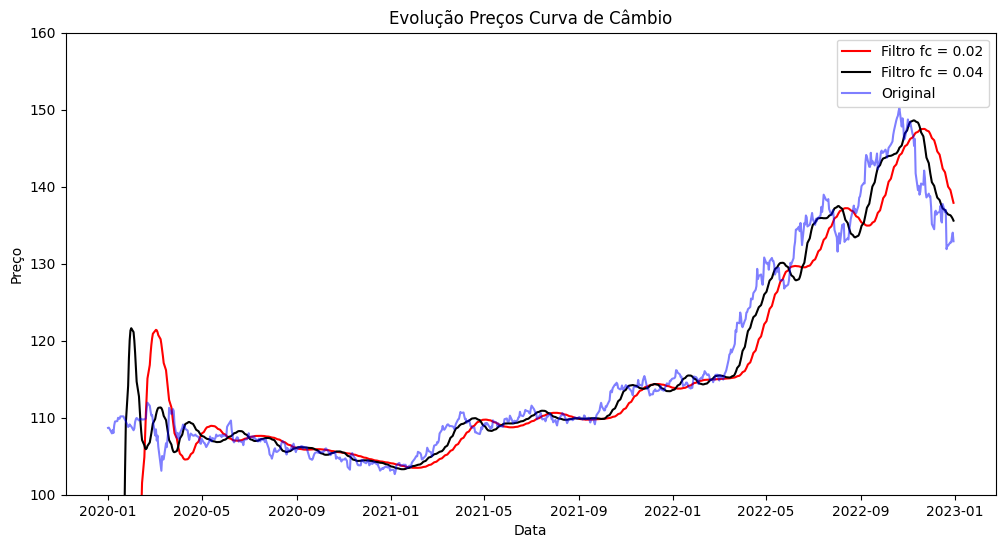

In [42]:
plt.figure(figsize=(12, 6))

plt.plot(usd_jpy_data_subset['Close'].index, filtered_log_return_2, color="red", label="Filtro fc = 0.02")
plt.plot(usd_jpy_data_subset['Close'].index, filtered_log_return_4, color="black", label="Filtro fc = 0.04")
plt.plot(usd_jpy_data_subset['Close'].index, usd_jpy_data_subset['Close'], color="blue", alpha=0.5, label="Original")
plt.title('Evolução Preços Curva de Câmbio')
plt.xlabel('Data')
plt.ylabel('Preço')

plt.ylim(100,160)

plt.legend()

plt.show()

Observamos que temos uma boa suavização, porém percebemos que quanto menor a frequência de corte, mais deslocado à direita o sinal filtrado está. Por mais que ocorra esse *shift* vemos que o sinal filtrado nos dá boas informações sobre tendências e possíveis ciclos. Relembrando, um filtro Butterworth depende de alguns parâmetros, aqui só modificamos a frequência de corte, vale a pena entender também os resultados ao modificar a freq. de amostragem e a ordem do filtro, mas não farei isso aqui.

<div id="cheb" />

#### Filtro Chebyshev

O filtro Chebyshev tem uma função de transferência da seguinte forma

$$
H(z) = \frac{1}{\sqrt{1+\epsilon^{2}C_{m}^{2}(e^{if}/f_{c})}}.
$$

Aqui vemos uma expressão mais complexa que o filtro anterior. Nesse filtro o $\epsilon$ é a taxa de oscilação na banda de rejeição e $C_{m}(x)$ é um polinômio de Chebyshev de ordem $m$.

In [43]:
def chebyshev_lowpass(data, cutoff_freq, sampling_freq, rp=0.1, order=4):
    nyquist = 0.5 * sampling_freq
    normal_cutoff = cutoff_freq / nyquist
    b, a = cheby1(order, rp, normal_cutoff, btype='low', analog=False)
    filtered_data = lfilter(b, a, data)
    return filtered_data

In [44]:
sampling_frequency = 1.0  

filtered_log_return2 = chebyshev_lowpass(daily_returns, 0.02, sampling_frequency)
filtered_log_return4 = chebyshev_lowpass(daily_returns, 0.04, sampling_frequency)

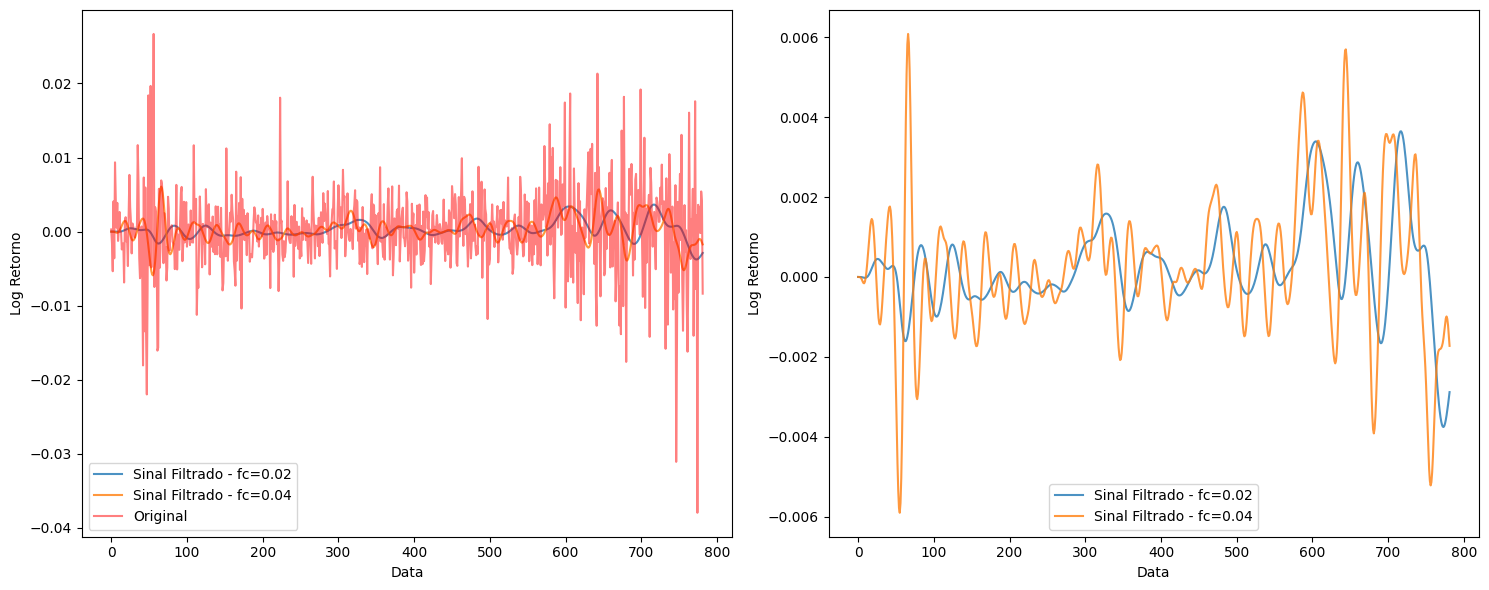

In [45]:
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

axs[0].plot(np.arange(len(filtered_log_return2)),filtered_log_return2, label='Sinal Filtrado - fc=0.02', alpha=0.8)
axs[0].plot(np.arange(len(filtered_log_return4)),filtered_log_return4, label='Sinal Filtrado - fc=0.04', alpha=0.8)
axs[0].plot(np.arange(len(filtered_log_return2)),daily_returns, label='Original', color="red", alpha=0.5)
axs[0].set_xlabel('Data')
axs[0].set_ylabel('Log Retorno')
axs[0].legend()


axs[1].plot(filtered_log_return2, label='Sinal Filtrado - fc=0.02', alpha=0.8)
axs[1].plot(filtered_log_return4, label='Sinal Filtrado - fc=0.04', alpha=0.8)
axs[1].set_xlabel('Data')
axs[1].set_ylabel('Log Retorno')
axs[1].legend()

plt.tight_layout()

plt.show()

Observamos que o filtro Chebyshev retorna um sinal bastante suavizado. E enxergamos um resultado similar ao resultado do filtro Butterworth. Filtrando agora a série de preços.

In [46]:
sampling_frequency = 1.0  

filtered_log_return_2 = chebyshev_lowpass(usd_jpy_data_subset['Close'], 0.02, sampling_frequency)
filtered_log_return_4 = chebyshev_lowpass(usd_jpy_data_subset['Close'], 0.04, sampling_frequency)

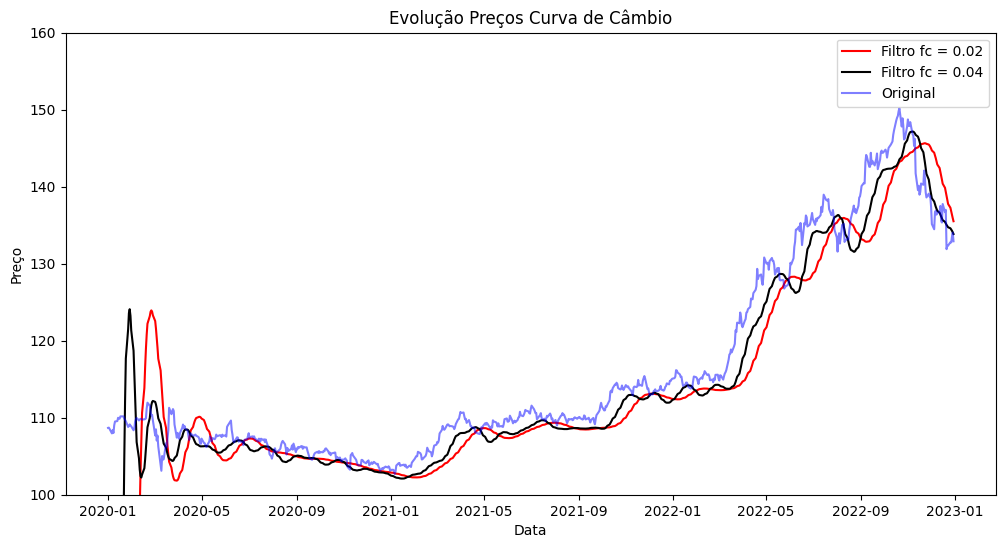

In [47]:
plt.figure(figsize=(12, 6))

plt.plot(usd_jpy_data_subset['Close'].index, filtered_log_return_2, color="red", label="Filtro fc = 0.02")
plt.plot(usd_jpy_data_subset['Close'].index, filtered_log_return_4, color="black", label="Filtro fc = 0.04")
plt.plot(usd_jpy_data_subset['Close'].index, usd_jpy_data_subset['Close'], color="blue", alpha=0.5, label="Original")
plt.title('Evolução Preços Curva de Câmbio')
plt.xlabel('Data')
plt.ylabel('Preço')

plt.ylim(100,160)

plt.legend()

plt.show()

Novamente observamos um sinal filtrado bem suavizado. Porém observamos novamente um *shift* à direita à medida que diminuimos a frequência de corte.

<div id="eliptico" />

#### Filtro Elíptico

A expressão $H(z)$ para esse tipo de filtro é bastante complexa. Ao invés disso, vamos observar $|H(f)|$ que é a magnitude (ou módulo) da função de transferência em função da frequência.

$$
    |H(f)| = \frac{1}{\sqrt{1+\epsilon^{2}R^{2}(f)}}
$$

Onde $R(f)$ é a função de Rosenbruck

$$
R(f) = \sqrt{1-\left( \frac{f}{f_{c}} \right)^{2}}
$$

In [58]:
def elliptic_lowpass(data, cutoff_freq, sampling_freq, rp=1.0, rs=40.0, order=4):
    nyquist = 0.5 * sampling_freq
    normal_cutoff = cutoff_freq / nyquist
    b, a = ellip(order, rp, rs, normal_cutoff, btype='low', analog=False)
    filtered_data = lfilter(b, a, data)
    return filtered_data[:len(data)]


In [49]:
sampling_frequency = 1.0  

filtered_log_return2 = elliptic_lowpass(daily_returns, 0.02, sampling_frequency)
filtered_log_return4 = elliptic_lowpass(daily_returns, 0.04, sampling_frequency)

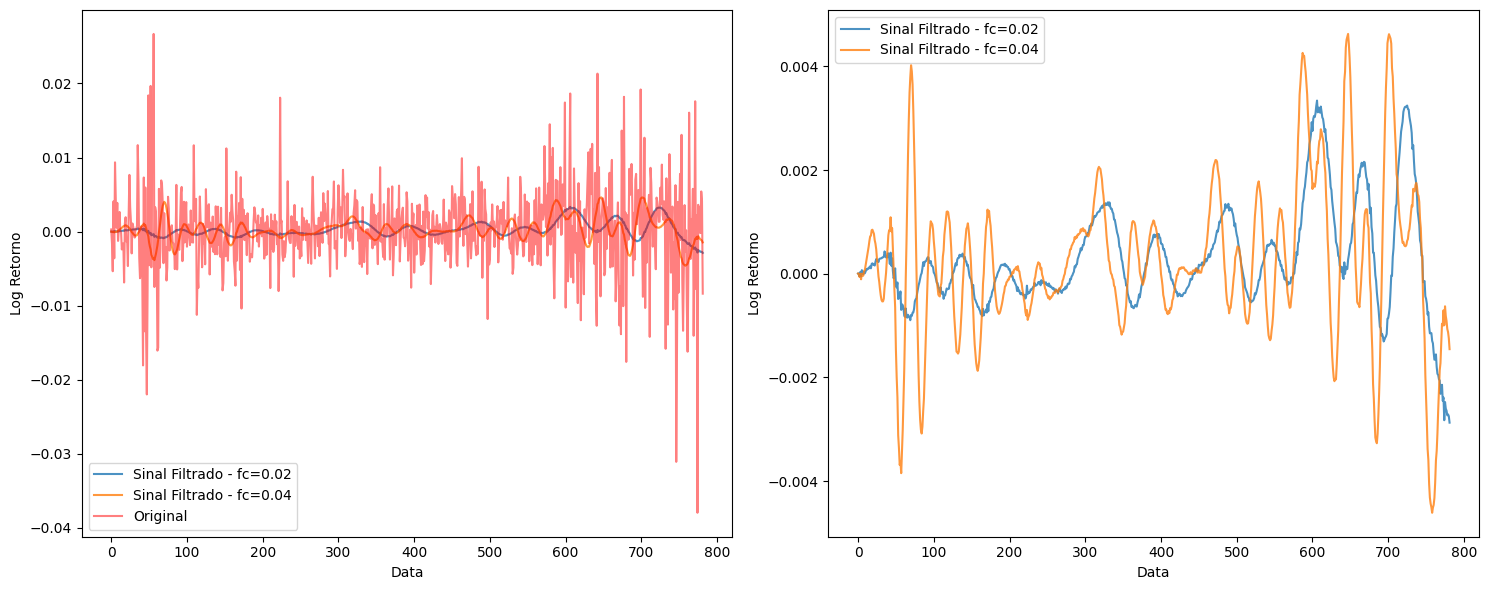

In [50]:
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

axs[0].plot(np.arange(len(filtered_log_return2)),filtered_log_return2, label='Sinal Filtrado - fc=0.02', alpha=0.8)
axs[0].plot(np.arange(len(filtered_log_return4)),filtered_log_return4, label='Sinal Filtrado - fc=0.04', alpha=0.8)
axs[0].plot(np.arange(len(filtered_log_return2)),daily_returns, label='Original', color="red", alpha=0.5)
axs[0].set_xlabel('Data')
axs[0].set_ylabel('Log Retorno')
axs[0].legend()


axs[1].plot(filtered_log_return2, label='Sinal Filtrado - fc=0.02', alpha=0.8)
axs[1].plot(filtered_log_return4, label='Sinal Filtrado - fc=0.04', alpha=0.8)
axs[1].set_xlabel('Data')
axs[1].set_ylabel('Log Retorno')
axs[1].legend()

plt.tight_layout()

plt.show()

Diferente dos outros filtros IIR tratados anteriormente, o sinal filtrado no filtro Elíptico, para $f_{c} = 0.02 \ Hz$ apresenta um certo ruído. Vamos, novamente, avaliar o filtro aplicado na série de preços.

In [56]:
sampling_frequency = 1.0  

filtered_log_return_2 = elliptic_lowpass(usd_jpy_data_subset['Close'], 0.02, sampling_frequency, rp=0.05)
filtered_log_return_4 = elliptic_lowpass(usd_jpy_data_subset['Close'], 0.04, sampling_frequency, rp=0.05)

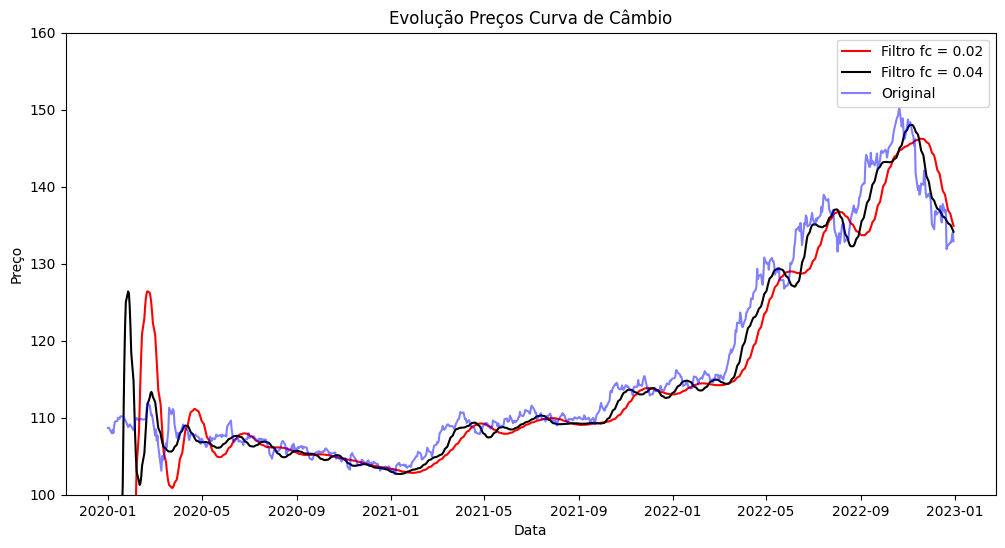

In [52]:
plt.figure(figsize=(12, 6))

plt.plot(usd_jpy_data_subset['Close'].index, filtered_log_return_2, color="red", label="Filtro fc = 0.02")
plt.plot(usd_jpy_data_subset['Close'].index, filtered_log_return_4, color="black", label="Filtro fc = 0.04")
plt.plot(usd_jpy_data_subset['Close'].index, usd_jpy_data_subset['Close'], color="blue", alpha=0.5, label="Original")
plt.title('Evolução Preços Curva de Câmbio')
plt.xlabel('Data')
plt.ylabel('Preço')

plt.ylim(100,160)

plt.legend()

plt.show()

Similar ao resultados anteriores, o filtro mostra uma certa eficiência ao realizar o filtro.